In [1]:
from abc import ABC, abstractmethod
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.ndimage.interpolation import shift
import warnings
warnings.filterwarnings("ignore")

# Backtest Environment Parent Class Definition (Godfather part of the code)

In [2]:
class Backtest_Environment(ABC):
    """
    This class contains the methods required to instantiate an environment for creating a backtest strategy. The methods 
    include abstract methods, static methods, and normal methods. A child "Strategy" will inherit each of these methods but
    require the definition of 3 abstract methods to become a full strategy. Those methods are:
    
    - process()
    - monitorPosition()
    - backtest()
    
    The first two contain the entry and exit rules/conditions of the strategy respectively. process() should return the number
    of units to purchase given favourable conditions for creating a position while monitorPosition returns a boolean on whether
    or not a position should be exited. 
    backtest() contains the entire for loop logic - all the class functions are brought together here and it is the key function
    to run in order to produce the backtest's results. 
    """
    
    def __init__(self, data, start_cash, pos_size, tc, cooldown=1, max_executions=None, max_execution_period=None, cash_buffer=0, stoploss=None):
        self.data = data # storing the data as a class variable
        self.start_cash = int(start_cash) # storing a specific variable for starting cash
        self.cash_available = start_cash # storing starting cash in a constantly updated variable
        self.cash_buffer = int(cash_buffer*self.start_cash) # option buffer amount
        self.cash_time_series = np.array([float(start_cash)]) # initialises a time series of the internal portfolio's cash value
        self.units_held = np.array([int(0)])
        self.openPositions = list() # or can make this dictionary (?) with date timestamp as key
        self.closedPositions = list() # or can make this dictionary (?) with date timestamp as key
        self.pos_size = pos_size
        self.tc = tc # transaction costs
        self.cooldown = cooldown # initialising cooldown to 0 so that a trades can occur
        self.max_executions = max_executions # maxmium executions
        self.max_execution_period = max_execution_period # maximum execution period
        self.stoploss = stoploss # setting the stoploss
        
        # adding the stoploss to the data
        if self.stoploss is not None:
            self.data["StopLoss"] = self.data["Price"] * (1 - self.stoploss)
            
        else:
            self.data["StopLoss"] = 0
    
    
    @abstractmethod
    def process(self):
        """
        Function that processes the daily input and returns the number of units of the asset that the back-tester should 
        purchase given a positive decision. 
        If no position is to be taken, the function should return 0.
        """
        pass
    
    @abstractmethod
    def monitorPosition(self, data, position):
        """
        Takes input of price and position to monitor. Checks if current price is greater than the target price of 
        the position. 
        
        Requires input of:
            - position to monitor
            - current price (in the "data" variable - data variable contains row of that day's
            new data)
            
        The output of running this function is: 
            - True if the position has hit it's target and needs to be closed
            - False if the position has not hit it's target and must remain open
        """
    
        pass
    
    @abstractmethod
    def backtest(self):
        """
        This function simulates the actions taken on each respective day of the trading strategy.
        The variable "data_row" contains all the necessary trading information to take a decision
        each day. 
        
        Transaction costs are applied in this function depending on whether they are greater than or
        less than 1; the former treated as absolute, the latter as a %. 
        
        Trades Initialised -> Trades Monitored/Updated -> Cash Value Updated
        """
            
        pass
    
    def openPosition(self, price, units, date, target_price = None, stoploss = None):
        """
        Standardised function across strategy backtest classes that takes input of:
        - next day's Open price
        - number of units
        - next day's date
        - optional target price
        
        and returns a dataframe containing all the relevant information contained with an open position.
        To be called within backtest() and created open positions should be appended to self.openPositions.
        """
        
        # ORDER PARAMETERS
        status = True # order status
        position_id = len(self.openPositions) # position identifier
        num_units = units # units of stock to buy
        entry_price = price
        entry_date = date # date of purchase
        pos_val = num_units * entry_price # calculating value of position (pre transaction cost)

        # returning a pandas dataframe
        return pd.DataFrame([[status, position_id, num_units, entry_price, entry_date, target_price, stoploss, pos_val]], 
                            columns=["Status", "PosID", "Units", "EntryPrice", "EntryDate", "PosTarget", "StopLoss", "PosVal"])
    
    def closePosition(self, position, price, date):
        """
        Standardised function that takes input of:
            - an open order (dataframe)
            - the next day's open price (day which the transaction is undertaken)
            - the next day's date
            
        and returns a closed position - which is to be appended to the list self.closedPositions, in class
        method backtest(). 
        """
        
        position["Status"] = False # updating the position status 
        position["ExitPrice"] = price # exit price
        position["ExitDate"] = date # exit date
        position["CashGainLoss"] = position["Units"]*(position["ExitPrice"] - position["EntryPrice"]) # calculating cash gain/loss
        position["PercGainPreTC"] = position["CashGainLoss"]/(position["Units"]*position["EntryPrice"])
        position["WinLoss"] = np.sign(position["CashGainLoss"])
        
        # add more metrics - continue adding over time based on necessary statistics
        
        return position
    
    def totalUnits(self):
        """
        Function returns total units held in open positions.
        """
        
        # counter
        total_units = 0
        
        # iterating through each open position
        for position in self.openPositions:
            
            # adding up all the units in total units
            total_units += int(position.Units.values[0])
            
        return int(total_units)
    
    def changePositionStatus(self, position):
        """
        Turns a position's status from True to False. Is called whenever an open order is closed. 
        """
        
        position.Status = False
        
        
        return position
    
    def removeInactiveOrders(self):
        """
        Function that iterates through the list of open positions and copies all active positions into a new list
        and updates the class variable to that list i.e. removing all inactive open positions.
        
        This function works in tandem with self.changePositionStatus() - it is to be run in backtest() after each position
        has been scanned.
        """
        
        # temporary list to store all active positions
        tmp = []
        
        # while the size of the open positions list is at least 1
        while len(self.openPositions) >= 1:
            
            # pop each position off
            position = self.openPositions.pop()
            
            # if the position is active then store it in the temporary list
            if position.Status.values == True:
                tmp.append(position)
        
        return tmp
    
    def updatedCash(self, data):
        """
        Outputs the current cash value of the portfolio by summating the product of the current 
        day's close price and the total units held with the available cash after all positions have 
        been opened/closed.
        """
        
        # Calculating current cash value of portfolio
        tmp_cash = self.cash_available + self.totalUnits()*data.NDOpen.values[0]
        
        return tmp_cash
    
    def check_executions(self, executions):
        """
        Checks if executions are within the limit. 
        """
        
        # verifies if executions equals none, in that case always returns True
        if self.max_executions == None:
            return True
        
        elif executions < self.max_exections:
            return True
        
        else:
            return False
    
    ### STATISTICS FUNCTION
    def statistics(self):
        """
        Calculates and outputs a dataframe containing the full performance statistics of the strategy.
        This function is to be called at the end of backtest() once the entire backtest for loop has been completed. 
        """
        
        # making the cash time series np array into a portfolio time series dataframe indexed by date (useful for calculating VARs)
        self.portfolio_time_series = pd.DataFrame(self.cash_time_series[1:]).set_index(self.data["NDDate"])

        # initialising variables that will be used as counters
        avg_perc_ch = 0
        avg_bars_held = 0
        avg_amount_ch = 0

        winners = 0
        avg_win_bars_held = 0
        avg_winner_perc = 0
        win_prof = 0
        consec_wins = 0
        max_consec_wins = 0
        big_win = 0

        losers = 0
        avg_lose_bars_held = 0
        avg_loser_perc = 0
        lose_prof = 0
        consec_losses = 0
        max_consec_losses = 0
        big_loss = 0

        for position in self.closedPositions:

            avg_perc_ch += position.PercGainPreTC.values[0]
            avg_bars_held += (position.ExitDate[0]  - position.EntryDate[0]).days
            avg_amount_ch += position.CashGainLoss.values[0] 

            # winner stats calculations
            winners += 1 if position.WinLoss.values[0] == 1 else int(0)
            avg_win_bars_held += (position.ExitDate[0]  - position.EntryDate[0]).days if position.WinLoss.values[0] == 1 else int(0)
            avg_winner_perc += position.PercGainPreTC.values[0] if position.WinLoss.values[0] == 1 else int(0)
            win_prof += position.CashGainLoss.values[0] if position.WinLoss.values[0] == 1 else int(0)
            consec_wins = consec_wins + 1 if (position.WinLoss.values[0] == 1) else int(0)
            max_consec_wins = max(max_consec_wins, consec_wins)
            big_win = max(big_win, position.CashGainLoss.values[0] if position.WinLoss.values[0] == 1 else int(0))

            # loser stats calculations
            losers += 1 if position.WinLoss.values[0] == -1 else int(0)
            avg_lose_bars_held += (position.ExitDate[0]  - position.EntryDate[0]).days if position.WinLoss.values[0] == -1 else int(0)
            avg_loser_perc += position.PercGainPreTC.values[0] if position.WinLoss.values[0] == -1 else int(0)
            lose_prof += position.CashGainLoss.values[0] if position.WinLoss.values[0] == -1 else int(0)
            consec_losses = consec_losses + 1 if position.WinLoss.values[0] == -1 else int(0)
            max_consec_losses = max(max_consec_losses, consec_losses)
            big_loss = min(big_loss, position.CashGainLoss.values[0] if position.WinLoss.values[0] == -1 else int(0))

            # position specific calculations 
            pos_time_series = self.data[position.EntryDate.values[0]:position.ExitDate.values[0]]["Open"].values * position.Units.values[0]
            position["Max DD Value"], position["Max DD Return"] = self.__class__.max_dd(pos_time_series)
            position["Holding Time"] = (position.ExitDate[0]  - position.EntryDate[0]).days

        self.positions = self.__class__.return_df_of_pos(self.closedPositions)

        # back-test stats
        init_cap = self.cash_time_series[0]
        end_cap = self.cash_time_series[-1]
        total_net_prof = (end_cap - init_cap)
        net_prof_perc = total_net_prof/init_cap
        exposure = self.calc_exposure(self.positions)
        ann_ret = (1 + net_prof_perc)**(252/len(self.data)) - 1
        trans_costs = self.total_tcost()
        port_max_dd_val, port_max_dd_perc = self.__class__.max_dd(self.cash_time_series)
        one_day_95_var = self.var(self.cash_time_series, 0.95)
        one_day_95_cvar = self.cvar(self.cash_time_series, 0.95)
        one_day_99_var = self.var(self.cash_time_series, 0.99)
        one_day_99_cvar = self.cvar(self.cash_time_series, 0.99)

        # total trade stats
        total_trades = len(self.closedPositions)
        avg_amount_ch = avg_amount_ch/len(self.closedPositions)
        avg_perc_ch = avg_perc_ch/len(self.closedPositions)
        avg_bars_held = avg_bars_held/len(self.closedPositions)
        avg_dd_abs = self.positions["Max DD Value"].mean()
        avg_dd_perc = self.positions["Max DD Return"].mean()
        max_dd_abs = self.positions["Max DD Value"].max()
        max_dd_perc = self.positions["Max DD Return"].min()

        # winner stats
        winners = winners
        win_perc = round(winners/len(self.closedPositions), 2)
        avg_win_prof = win_prof/winners
        avg_winner_perc = avg_winner_perc/winners
        avg_win_bars_held = avg_win_bars_held/winners
        max_consec_wins = max_consec_wins
        big_win_bars_held = (self.positions[self.positions["CashGainLoss"] == big_win].ExitDate - self.positions[self.positions["CashGainLoss"] == big_win].EntryDate)[0].days

        # loser stats
        losers = losers 
        lose_perc = round(losers/len(self.closedPositions), 2)
        avg_lose_prof = lose_prof/losers
        avg_loser_perc = avg_loser_perc/losers
        avg_lose_bars_held = avg_lose_bars_held/losers
        max_consec_losses = max_consec_losses
        big_loss_bars_held = (self.positions[self.positions["CashGainLoss"] == big_loss].ExitDate - self.positions[self.positions["CashGainLoss"] == big_loss].EntryDate)[0].days

        columns = ["Initial Capital", "Ending Capital", "Total Profit", "Total Profit Percentage", "Exposure", "Annual Return", "Transaction Costs", "Portfolio Max DD Value", "Portfolio Max DD Perc", "1 Day 95% VAR", "1 Day 95% CVAR", "1 Day 99% VAR", "1 Day 99% CVAR",
                   "Total Trades", "Avg Gain/Loss", "Avg Percentage Gain/Loss", "Avg Bars Held", "Avg Max DD Value", "Avg Max DD Percentage", "Max DD Trade Value", "Max DD Trade Percentage",
                   "Winners", "Win Percentage", "Win Profits", "Avg Win Profit", "Avg Win Percentage", "Avg Win Bars Held", "Max Consecutive Wins", "Biggest Win", "Biggest Win Bars Held", 
                   "Losers", "Lose Percentage", "Loss Losses", "Avg Lose Profit", "Avg Lose Percentage", "Avg Lose Bars Held", "Max Consecutive Losses", "Biggest Loss", "Biggest Loss Bars Held"]

        self.stats = pd.DataFrame([[init_cap, end_cap, total_net_prof, net_prof_perc, exposure, ann_ret, trans_costs, port_max_dd_val, port_max_dd_perc, one_day_95_var, one_day_95_cvar, one_day_99_var, one_day_99_cvar,
                      total_trades, avg_amount_ch, avg_perc_ch, avg_bars_held, avg_dd_abs, avg_dd_perc, max_dd_abs, max_dd_perc, 
                      winners, win_perc, win_prof, avg_win_prof, avg_winner_perc, avg_win_bars_held, max_consec_wins, big_win, big_win_bars_held,
                      losers, lose_perc, lose_prof, avg_lose_prof, avg_loser_perc, avg_lose_bars_held, max_consec_losses, big_loss, big_loss_bars_held]], 
                     columns=columns)

        return 

    ### Functions to calculate statistics
    def total_tcost(self):
        """
        Calculates the total transaction costs paid throughout the backtesting of the portfolio. 
        """

        total_tc = 0

        if self.tc >= 1:
            # transaction cost for every completed order during opening and closing (hence x2)
            total_tc = (len(self.closedPositions) * 2 * self.tc) + (len(self.openPositions) * self.tc)

        else:
            for position in self.closedPositions:
                total_tc += (position.EntryPrice.values[0]*position.Units.values[0]*self.tc) + (position.ExitPrice.values[0]*position.Units.values[0]*self.tc)

            for position in self.openPositions:
                total_tc += (position.EntryPrice.values[0]*position.Units.values[0]*self.tc)

        return total_tc
    
    def calc_exposure(self, positions):
        """
        This function calculates the exposure of the trading strategy. It requires the class attribute self.pos_df which contains 
        a dataframe with each closed position as a row, holding all the main information regarding that closed position. It returns
        a decimal value for the exposure. 
        """

        # maintaining temporary variables for each exposure interval
        curr_exp_start = 0
        curr_exp_end = 0
        curr_exp = 0

        # initialising starting exposure variables
        curr_exp_start = positions.iloc[0, :].EntryDate
        curr_exp_end = positions.iloc[0, :].ExitDate
        curr_exp = int((curr_exp_end - curr_exp_start).days)

        # list for maintaing integers of exposure intervals
        exp_int = []

        for i in range(1, len(positions)):

            # checking if the new position was OPENED BEFORE the closing of the previous position (overlap)
            if positions.iloc[i, :].EntryDate <=  positions.iloc[i-1, :].ExitDate:
                pass

            # condition triggered when new position is OEPNED AFTER the close of the previous position
            # an exposure interval has ended and variables must be re-assigned 
            else: 

                # appending previous exposure interval to list
                exp_int.append(curr_exp)

                # updating current exposure start and end dates
                curr_exp_start = positions.iloc[i, :].EntryDate
                curr_exp_end = positions.iloc[i, :].ExitDate

                # subtracting weekends
                curr_exp = int((curr_exp_end - curr_exp_start).days) - self.__class__.no_weekends(curr_exp_start, curr_exp_end)

            # checking if the new position CLOSED AFTER close of the previous position (extend exposure)
            if positions.iloc[i, :].ExitDate >  positions.iloc[i-1, :].ExitDate:
                curr_exp_end = positions.iloc[i, :].ExitDate

            # condition triggered when new position closes BEFORE close of the previous position
            else:
                pass

        # subtracting weekends and setting exposure equal to sum of exposed periods divided by total days between dataset 
        # start and end dates with weekends / non-business days subtracted
        exposure = round(np.sum(exp_int)/(int((self.data.index[-1] - self.data.index[0]).days) - self.__class__.no_weekends(self.data.index[0], self.data.index[-1])), 2)

        # return exposure as percentage decimal
        return exposure
    
    def var(self, price_series, alpha):
        """
        Calculates the historical daily value at risk of the portfolio. The steps taken are:
        - calculate the returns of the portfolio
        - sort the returns
        - find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        - return the VAR value
        """

        # calculate the returns of the portfolio
        p_ret = self.ret(price_series)

        # sort the returns
        sorted_p_ret = np.sort(p_ret)[::-1]

        # find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        a_idx = int(np.round(alpha * len(p_ret)))

        # VAR value
        Var = sorted_p_ret[a_idx]

        return Var

    def cvar(self, price_series, alpha):
        """
        Calculates the historical daily Conditional Value at Risk (or Expected Shortfall). The steps taken are:
        - calculate the returns of the portfolio
        - sort the returns
        - find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        - take the average of the values of returns that are below the var value corresponding the alpha'th index 
        """
        # calculate the returns of the portfolio
        p_ret = self.ret(price_series)

        # sort the returns
        sorted_p_ret = np.sort(p_ret)[::-1]

        # find the index value closest to the alpha'th return: where alpha corresponds to the var certainty
        a_idx = int(np.round(alpha * len(p_ret)))

        # calculates CVar/Expected Shortfall (ES) by taking the average of the worst 1 - alpha % of cases
        CVar = np.mean(sorted_p_ret[a_idx:])

        return CVar 
    
    ### STATIC METHODS
    
    @staticmethod
    def return_df_of_pos(list_of_pos):
        """
        Takes input of a list of positions and returns a dataframe of those positions. 
        """
        
        if len(list_of_pos) == 0:
            return pd.DataFrame()

        # setting positions_dfequal to first closed position dataframe accessed via class variable
        df_of_pos = list_of_pos[0]

        # iterating through each position from the second onwards
        for i, pos in enumerate(list_of_pos, start=1):

            # enumerate goes till i equals the size of list, hence a break condition is in place to trigger on last iteration
            if i == len(list_of_pos): break

            # appending next row to positions_dfdf    
            df_of_pos = df_of_pos.append(list_of_pos[i]) 

        # sorting by date entered
        df_of_pos = df_of_pos.sort_values("EntryDate")

        return df_of_pos 
    
    @staticmethod
    def no_weekends(date1, date2):
        """
        Calculates the number of weekends/ non-business days between two dates. 
        """

        # generating dates
        dates = (date1 + timedelta(1 + idx)
                 for idx in range((date2 - date1).days))

        # summing all weekdays
        res = sum(1 for day in dates if day.weekday() < 5)

        # getting number of weekends
        weekends = int((date2 - date1).days) - res

        # return number of weekends / non-business days
        return weekends
    
    @staticmethod
    def ret(pos_time_series):
        """
        This function takes in a numpy array repreenting a price time series. It outputs the return time series. 
        """
        rets = np.delete((shift(pos_time_series, -1) - pos_time_series)/pos_time_series, -1)
        return rets

    @staticmethod
    def max_dd(data):
        """
        This function returns the max drawdown of an input price series. 
        """

        # obtains the index of the minimum point in the time series 
        p = np.argmax(np.maximum.accumulate(data) - data)

        # in the event there is no drawdown
        if p == 0:
            return 0, 0

        else:
            # obtaining the maximum point prior to p 
            q = np.argmax(data[:p])

            # calculating the drawdown: absolute value and percentage
            max_dd_abs = np.round(data[q] - data[p], 3)
            max_dd_perc = np.round((data[p]-data[q])/data[q], 3)

            # returning max drawdown to 3 decimal places
            return max_dd_abs, max_dd_perc
     
    # ANALYSIS functions: graphs and any other plots
    def exec_per_period(self, period):
        """
        Takes an input of period and outputs the number of executions that occurred every "period" number of days in a block
        by block basis (i.e. not a rolling basis)
        """

        executions_per_period = []
        executions_this_period = 0
        last_week = 0
        pos_idx = 0
        date_idx = []

        for i, date in enumerate(self.data.index):

            if pos_idx == len(self.positions):
                break

            if date == self.positions.iloc[pos_idx, :].EntryDate:
                executions_this_period += 1
                pos_idx += 1

            if i - last_week >= period:
                executions_per_period.append(executions_this_period)
                date_idx.append(date)
                executions_this_period = 0
                last_week = i

        plt.title("Number of executions every {} days".format(period))
        plt.stem(date_idx, executions_per_period)
        plt.grid()

        return 

# Example Strategy Class Definition (Lieutenant)

In [3]:
class BullHighBreakout(Backtest_Environment):
    
    # first line of arguments contains strategy specific parameters, second line contains backtest environment parameters
    def __init__(self, data, mltv, sttv, start_date, end_date,
                 start_cash, pos_size, tc, cooldown=1, max_executions=None, max_execution_period=None, cash_buffer=0, stoploss=None):
        """
        Constructor method for the strategy child class. Extra arguments specific to the child can be added to this 
        constructor.
        
        The benefit of this is that, strategy specific parameters can be added to this class with the data preparation 
        methods occurring within the class prior to backtest(). 
        
        This structure allows for an easier defintion of new strategies for strategies with the similar rule structures
        but different parameters applied to those rules. 
        """
        
        # Strategy specific parameters
        self.data = data
        self.mltv = mltv
        self.sttv = sttv
        self.start_date = start_date
        self.end_date = end_date
        self.data = self.format_data()
        
        # Calling the backtest parent class constructor method
        super().__init__(self.data, start_cash, pos_size, tc, cooldown, max_executions, max_execution_period, cash_buffer, stoploss)
        
    def format_data(self):
        """
        Prepares data according to the 3 indicators that the strategy requires. The data required is:

        - medium-long term indicator (MLTI): rule 1 - the strategy only initiates a trade when above this value (calculated
        using mltv)
        - short term trade indicator (STTI): rule 2 - the strategy enters positions when the price falls below this value 
        and rule 1 is satisfied (calculated using sttv).
        - position target (PosTarget): rule 3 - the exit conditon relies on this indicator. The strategy exits positions when the 
        price surpasses this value (calculated using sttv). 

        The inputs are:
        - data: any price dataframe containing the columns "Close" and "Open" -
        - mltv: explained above
        - sttv: explained above
        - start_date: self explanatory
        - end_date: self explanatory
        """

        # formatting the name of the close price data (column name utilised in backtest() method)
        self.data = self.data.rename(columns={"Close": "Price"}) # getting current day close in right format for class input
        self.data = self.data[["Price", "Open"]] # process price and current day's open (the latter being strategy specific)

        # STRATEGY AGNOSTIC COLUMNS
        nddate = self.data.index.values[1:] # tmp array for next day dates
        self.data["NDOpen"] = self.data["Open"].shift(-1) # next day open: the price on which trade decisions made at the prev close are taken
        self.data = self.data.dropna() # dropping nan to make space for date[1:] values converted into datetime values 
        self.data["NDDate"] = pd.to_datetime(nddate) # next day date: the date on which trade decisions made at prev close are taken

        # STRATEGY SPECIFIC COLUMNS
        self.data["MLTI"] = self.data["Price"].rolling(self.mltv).mean() # medium-long term indicator: 200 day moving average
        self.data["STTI"] = self.data["Price"].rolling(self.sttv).mean() # short term trade indicator
        self.data["PosTarget"] = self.data["Price"].rolling(self.sttv).max() # position target: 1 week high

        # accessing dates of interest
        self.data = self.data.loc[self.start_date:self.end_date] # indexing dataframe between the dates of interest once all indicators are calculated

        return self.data
    
    def process(self, data):
        """
        Takes input data which includes: 
        - a Medium to Long Term Indicator (MLTI)
        - a Short Term Trend Indicator (STTI)
        
        in a pandas Dataframe.
        
        This function runs through the logic behind initialising a trade for this strategy. 
        The variable MTLI is a 200 day MA. The variable STTI is a 7 day MA. 
        
        The Logic for opening positions:
        
        - If the price is greater than the MLTI, we proceed
        - If the price is below the 7 day MA (trending low), proceed 
        - If cash after position opens is greater than buffer: 
            - return num_units: indicating output of the decision process is positive, open a position with number
            of units equal to num_units in backtest()
        """
        
        # long term condition satisfied e.g > 200 day MA
        if data.Price.values[0] > data["MLTI"].values[0]:
            
            # short term condition satisfied: < e.g < 7 day MA
            if data.Price.values[0] < data["STTI"].values[0]:
                
                # calculate number of units
                num_units = int(np.floor((self.pos_size * self.cash_available) / data.Price.values[0]))
                
                # cash check - acts as a lid on opening new positions
                if (self.cash_available - num_units*data.Price.values[0]) > self.cash_buffer:
                    
                    return num_units
                
                else:
                    return 0
            
        return 0

    
    def monitorPosition(self, data, position):
        """
        Takes input of price and position to monitor. Checks if current price is greater than the target price of 
        the position. 
        
        Requires input of:
            - position to monitor
            - current price (in the "data" variable - data variable contains row of that day's
            new data)
            
        The output of running this function is: 
            - True if the position has hit it's target and needs to be closed
            - False if the position has not hit it's target and must remain open
        """
        
                
        # checking if current price is greater than the position's target
        if data.Price.values[0] >= position.PosTarget.values[0]:
                    
            # return true
            return True
        
        # checking if price is less than stoploss
        elif data.Price.values[0] <= position.StopLoss.values[0]:
            
            # return true
            return True
        
        else:
            return False

    
    def backtest(self):
        """
        This function simulates the actions taken on each respective day of the trading strategy.
        The variable "data_row" contains all the necessary trading information to take a decision
        each day. 
        
        Transaction costs are applied in this function depending on whether they are greater than or
        less than 1; the former treated as absolute, the latter as a %. 
        
        Trades Initialised -> Trades Monitored/Updated -> Cash Value Updated
        """
        
        # start the cooldown value as 0 so trading can commence from day 1
        cooldown = 0
        
        # initialising a rolling executions variabale
        executions = 0
        
        # running through each day with all available information required in data_row
        for i in range(0, len(self.data)):
            
            # all data required for that day's trade processing
            data_row = self.data.iloc[i:i+1, :]

            # checking if exection max execution period is not None
            if self.max_execution_period is not None:
                # if the current day is a multiple of the max execution period, reset the executions
                if i%self.max_execution_period == 0:
                    executions = 0
            
            # decrement cooldown as a new day has started - cooldown is the max of 0 and its current value decremented 
            # this ensures cooldown never goes below 0 
            cooldown = max(0, cooldown - 1)

            # checking if # executions is < max allowed executions
            if self.check_executions(executions):
                
                # verifying that cooldown period has ended before checking to initialise a trade
                if cooldown == 0: 

                    # 1 TRADE INITIALISATION: if a trade is to be placed
                    if self.process(data_row) is not 0:

                        # incrementing executions 
                        executions += 1

                        # obtain number of units
                        num_units = self.process(data_row)

                        # OPEN a position (market order)
                        self.openPositions.append(self.openPosition(data_row.NDOpen.values[0], num_units, data_row.NDDate.values[0], data_row.PosTarget.values[0], data_row.StopLoss.values[0]))

                        # set the cooldown threshold to the initialised value once a position is opened
                        cooldown = self.cooldown 

                        # reducing the portfolio's cash
                        if self.tc >= 1:
                            self.cash_available = self.cash_available - num_units*data_row.NDOpen.values[0] - self.tc

                        elif self.tc < 1:
                            self.cash_available = self.cash_available - num_units*data_row.NDOpen.values[0] - num_units*data_row.NDOpen.values[0]*self.tc

                            
            # 2 TRADE MONITORING: monitoring activate trades by 
            # creating a false bool that turns true when an order closes
            order_closed = False
            
            #iterating throughe each open position
            for position in self.openPositions: 
                
                # checking if exit condition is met in self.monitorPosition()
                if self.monitorPosition(data_row, position) == True:
                    
                    # update order close bool - indicating that an order has closed today
                    order_closed = True
                    
                    # append the closed position to the closed Positions list
                    self.closedPositions.append(self.closePosition(position, data_row.NDOpen.values[0], data_row.NDDate.values[0]))
                    
                    # update the status of the open position
                    position = self.changePositionStatus(position)
                    
                    # update cash and charge transaction costs for closing position
                    if self.tc >= 1:
                        # need to add cash back after absolute transaction costs
                        self.cash_available = self.cash_available + position.Units.values[0]*data_row.NDOpen.values[0] - self.tc
                    
                    elif self.tc < 1:
                        # need to add cash back after % transaction costs
                        self.cash_available = self.cash_available + position.Units.values[0]*data_row.NDOpen.values[0] - position.Units.values[0]*data_row.NDOpen.values[0]*self.tc
                        
             
            # if an order(s) has closed, remove inactive orders is called
            if order_closed:
                
                # self.removeInactiveOrders() removes all inactive orders and returns list of only active order 
                # result stored in self.openPositions
                self.openPositions = self.removeInactiveOrders()
                    
            
            # UPDATING CASH
            self.cash_time_series = np.append(self.cash_time_series, self.updatedCash(data_row))
            self.units_held = np.append(self.units_held, self.totalUnits())
            
        # Strategy Statistics: calling the statistics function after the entire test set has been run through
        self.statistics()
        
        # return
        return True
    

## Getting Data into the Right Format
- move this into the strategy class and define the parameters required as inputs

In [4]:
# strategy specific parameters
aapl = yf.Ticker("AAPL").history(period="30y")
mltv = 200
sttv = 5
start_date = pd.to_datetime("2016-01-01")
end_date = pd.to_datetime("2021-10-06")

## Instantiating the Strategy and calling the Backtest() function with the desired input parameters

In [5]:
strat = BullHighBreakout(aapl, mltv, sttv, start_date, end_date,
                         start_cash=10000, pos_size=0.05, tc=2, cooldown=0, 
                         max_executions=None, max_execution_period=None, cash_buffer=0, stoploss = 0.1)

strat.backtest()

True

## Plotting the portfolio's cash time series

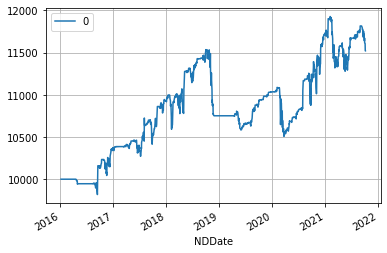

In [6]:
strat.portfolio_time_series.plot()
plt.grid()
plt.show()

## Dataframe read out of all closed positions and their relevant metrics

In [7]:
strat.positions

,Status,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss,Max DD Value,Max DD Return,Holding Time
0,False,0,19,25.239138,2016-04-18,25.983168,22.915491,479.543620,22.624592,2016-04-28,-49.676371,-0.103591,-1.0,56.767,-0.118,10
0,False,0,19,25.270113,2016-08-12,25.511602,22.774754,480.132145,25.703865,2016-08-16,8.241296,0.017165,1.0,0.000,0.000,4
0,False,1,18,25.354516,2016-08-15,25.511602,22.827508,456.381289,25.703865,2016-08-16,6.288287,0.013779,1.0,0.000,0.000,1
0,False,0,19,25.460023,2016-08-23,25.645250,22.897144,483.740430,26.695633,2016-09-15,23.476595,0.048531,1.0,26.461,-0.055,23
0,False,1,18,25.455333,2016-08-24,25.640560,22.968884,458.195986,26.695633,2016-09-15,22.325406,0.048725,1.0,24.984,-0.055,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,False,1,3,147.440002,2021-08-20,151.119995,132.029997,442.320007,152.660004,2021-08-31,15.660004,0.035404,1.0,6.990,-0.016,11
0,False,2,3,148.309998,2021-08-23,151.119995,133.371002,444.929993,152.660004,2021-08-31,13.050018,0.029330,1.0,6.990,-0.016,8
0,False,3,3,148.350006,2021-08-26,149.710007,133.524001,445.050018,152.660004,2021-08-31,12.929993,0.029053,1.0,2.610,-0.006,5
0,False,4,3,147.479996,2021-08-27,149.710007,132.785994,442.439987,152.660004,2021-08-31,15.540024,0.035123,1.0,0.000,0.000,4


## Dataframe readout of strategy's full performance statistics

In [8]:
strat.stats.T

,0
Initial Capital,10000.000000
Ending Capital,11521.275896
Total Profit,1521.275896
Total Profit Percentage,0.152128
Exposure,0.640000
Annual Return,0.024916
Transaction Costs,1792.000000
Portfolio Max DD Value,1027.939000
Portfolio Max DD Perc,-0.089000
1 Day 95% VAR,-0.005361


## Plotting the number of executions per period of the strategy (risk management)

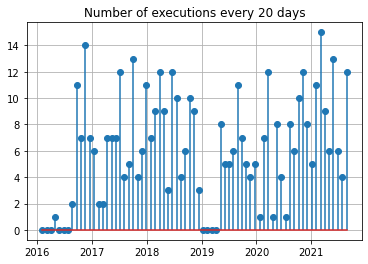

In [9]:
strat.exec_per_period(20)